# IBM Data Science Capstone Project 

## The Data
Although there were many datasets where I could get the data from, I decided to use the data from Wikipedia for each district for 2 reasons: First, Wikipedia is a reliable data source with a minimum amount of missing values. Second, This particular data set contained information about household income and population density which will be useful for the second part of the project. Regarding the location and venues, data was extracted from Foursquare API, one of the most reliable data sources for venues all around the world. To extract data from fourquare, coordinate data was necessary, hence, geocoder library was used to extract data about the coordinates of each district in Istanbul. Furthermore, folium mapmaker was used to plot the map of Istanbul with each district marked.

### Part 1/ 2: Finding the ideal place to open a restaurant in Istanbul

Istanbul is one of the largest and most touristic cities of the World. SUrely, a restaurant opened here will attract many customers and be successful. In this project, I am going to analyze the venues in Istabul by district and try to find the optimal to place to open a restaurant looking at the already existing nummber of restaurants in each district.

Importing the necessary libraries

In [293]:
!pip install geopy
!pip install geocoder
!pip install folium

import numpy as np
import pandas as pd
import json
from geopy.geocoders import Nominatim
import geocoder
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize
from sklearn.metrics import silhouette_score

%matplotlib notebook

print('All libraries imported.')

All libraries imported.Requirement already satisfied: branca in c:\programdata\anaconda3\lib\site-packages (from folium) (0.4.2)



I obtained the district names in Istanbul from Wikipedia 

In [294]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_districts_of_Istanbul')[0]
df = pd.DataFrame(df)
df

,District,Population (2020),Area (km²),Density (per km²),Mensual household income TL(USD),Annual household income TL(USD)
0,Adalar,16033,11.05,1451,6.652₺ (918$),"79.821₺ (10,978$)"
1,Arnavutköy,296709,450.35,659,2.030₺ (279$),"24.360₺ (3,350$)"
2,Ataşehir,422594,25.23,16750,6.577₺ (904$),"78.924₺ (10,854$)"
3,Avcılar,436897,42.01,10400,3.662₺ (503$),"43.938₺ (6,064$)"
4,Bağcılar,737206,22.36,32970,3.197₺ (441$),"38.367₺ (5,295$)"
5,Bahçelievler,592371,16.62,35642,4.674₺ (645$),"56.088₺ (7,741$)"
6,Bakırköy,226229,29.64,7633,"8.845₺ (1,220$)","106.140₺ (14,650$)"
7,Başakşehir,469924,104.30,4506,4.513₺ (622$),"54.152₺ (7,474$)"
8,Bayrampaşa,269950,9.61,28091,3.480₺ (480$),"41.762₺ (5,764$)"
9,Beşiktaş,176513,18.01,9801,"10.560₺ (1,457$)","126.720₺ (17,490$)"


In [295]:
#Drop irrelevant columns
df = df[['District','Population (2020)','Area (km²)']]
df

,District,Population (2020),Area (km²)
0,Adalar,16033,11.05
1,Arnavutköy,296709,450.35
2,Ataşehir,422594,25.23
3,Avcılar,436897,42.01
4,Bağcılar,737206,22.36
5,Bahçelievler,592371,16.62
6,Bakırköy,226229,29.64
7,Başakşehir,469924,104.30
8,Bayrampaşa,269950,9.61
9,Beşiktaş,176513,18.01


In [296]:
# Drop total row counts from the bottom rows
df = df.drop(df.index[39:42])
df

,District,Population (2020),Area (km²)
0,Adalar,16033,11.05
1,Arnavutköy,296709,450.35
2,Ataşehir,422594,25.23
3,Avcılar,436897,42.01
4,Bağcılar,737206,22.36
5,Bahçelievler,592371,16.62
6,Bakırköy,226229,29.64
7,Başakşehir,469924,104.30
8,Bayrampaşa,269950,9.61
9,Beşiktaş,176513,18.01


I obtained the latitude and longitude of the districts using the geocoder library

In [297]:
for i, neigh in enumerate(df['District']):
    lat_lng_coords = None
    
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, İstanbul, Turkey'.format(neigh))
        lat_lng_coords = g.latlng
    
    if lat_lng_coords:
        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]
    
    df.loc[i, 'Latitude1'] = latitude
    df.loc[i, 'Longitude1'] = longitude

df.head(10)

,District,Population (2020),Area (km²),Latitude1,Longitude1
0,Adalar,16033.0,11.05,40.86306,29.12423
1,Arnavutköy,296709.0,450.35,41.18558,28.74147
2,Ataşehir,422594.0,25.23,40.99248,29.12777
3,Avcılar,436897.0,42.01,40.97813,28.72101
4,Bağcılar,737206.0,22.36,41.03323,28.86351
5,Bahçelievler,592371.0,16.62,40.99805,28.84737
6,Bakırköy,226229.0,29.64,40.98273,28.87480
7,Başakşehir,469924.0,104.30,41.10745,28.80061
8,Bayrampaşa,269950.0,9.61,41.04381,28.91214
9,Beşiktaş,176513.0,18.01,41.04190,29.00575


In [298]:
#Renaming columns to be more clear
df.rename(columns={'Latitude1':'Latitude','Longitude1':'Longitude'},inplace = True)
df

,District,Population (2020),Area (km²),Latitude,Longitude
0,Adalar,16033.0,11.05,40.86306,29.12423
1,Arnavutköy,296709.0,450.35,41.18558,28.74147
2,Ataşehir,422594.0,25.23,40.99248,29.12777
3,Avcılar,436897.0,42.01,40.97813,28.72101
4,Bağcılar,737206.0,22.36,41.03323,28.86351
5,Bahçelievler,592371.0,16.62,40.99805,28.84737
6,Bakırköy,226229.0,29.64,40.98273,28.87480
7,Başakşehir,469924.0,104.30,41.10745,28.80061
8,Bayrampaşa,269950.0,9.61,41.04381,28.91214
9,Beşiktaş,176513.0,18.01,41.04190,29.00575


In [301]:
#Drop the last 3 indexes containing information about total values
df.drop(index = [42,39], inplace = True)
df

,District,Population (2020),Area (km²),Latitude,Longitude
0,Adalar,16033.0,11.05,40.86306,29.12423
1,Arnavutköy,296709.0,450.35,41.18558,28.74147
2,Ataşehir,422594.0,25.23,40.99248,29.12777
3,Avcılar,436897.0,42.01,40.97813,28.72101
4,Bağcılar,737206.0,22.36,41.03323,28.86351
5,Bahçelievler,592371.0,16.62,40.99805,28.84737
6,Bakırköy,226229.0,29.64,40.98273,28.87480
7,Başakşehir,469924.0,104.30,41.10745,28.80061
8,Bayrampaşa,269950.0,9.61,41.04381,28.91214
9,Beşiktaş,176513.0,18.01,41.04190,29.00575


Now, I will visualize the districts of Istanbul using Folium

In [291]:
#Obtain the coordinates of Istanbul using geolocator
address = 'İstanbul, TR'
geolocator = Nominatim(user_agent = 'Kaan Çaylan')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of İstanbul are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of İstanbul are 41.0096334, 28.9651646.


In [302]:
map_Ist = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, district in zip(df['Latitude'], df['Longitude'], df['District']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.8,
        parse_html=False).add_to(map_Ist)  
    
map_Ist

In [151]:
#Enter Foursquare API credentials to acces data 
CLIENT_ID = 'CVQXFW1S1Y40SBCZQYAXLNOYABUK5UFNLKMUEAKF0UGMR2C0' # your Foursquare ID
CLIENT_SECRET = 'ZUVOEIFOX4GXMFKKS2XXSVK1AUN2STUAGNX0JV0X2JXKTZYY' # your Foursquare Secret
ACCESS_TOKEN = '' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CVQXFW1S1Y40SBCZQYAXLNOYABUK5UFNLKMUEAKF0UGMR2C0
CLIENT_SECRET:ZUVOEIFOX4GXMFKKS2XXSVK1AUN2STUAGNX0JV0X2JXKTZYY


Let's start by exploring the first neighborhood in our dataframe using Foursquare API:

In [154]:
neighborhood_name = df.loc[0, 'District']
neighborhood_lat = df.loc[0, 'Latitude']
neighborhood_long = df.loc[0, 'Longitude']

print("The district is {} and it's geographical coordinates are {} latitude and {} longitude".format(neighborhood_name,
                                                                                                        neighborhood_lat, neighborhood_long))

The district is Adalar and it's geographical coordinates are 40.863060000000075 latitude and 29.12423000000007 longitude


Here, we will extract top 200 venues within 1 km radius by creating a url and using the'get' function to obtain the values

In [155]:
LIMIT = 200
radius = 1000

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_lat, 
    neighborhood_long, 
    radius, 
    LIMIT)

In [156]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '602695852776b86a581d98a9'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Nizam',
  'headerFullLocation': 'Nizam, Istanbul',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 67,
  'suggestedBounds': {'ne': {'lat': 40.87206000900009,
    'lng': 29.13610821854761},
   'sw': {'lat': 40.854059991000064, 'lng': 29.112351781452528}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '562b6d03498eccd0b5b1c200',
       'name': 'Büyükada Lale köşkü',
       'location': {'address': 'Kadıyoran Caddesi No 81',
        'lat': 40.86565719675016,
        'lng': 29.125222810357034,
        'labeledLatLngs': [{'label': 'display',
          'lat': 

We define a new function to obtain the category of the venues, we will use this to group the venues by category for each district.

In [157]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We use the function to categorize the venues and store them in dataframe format

In [159]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Büyükada Lale köşkü,Bed & Breakfast,40.865657,29.125223
1,Eski Rum Yetimhanesi,Historic Site,40.861705,29.123323
2,Büyükada Tepesi,Mountain,40.861107,29.117418
3,Büyükada Bisiklet Parkuru,Bike Trail,40.865000,29.116861
4,Büyükada Apart Hotel,Bed & Breakfast,40.867772,29.126980


In [161]:
print("{} venues were returned for {} by Foursquare".format(len(nearby_venues), neighborhood_name))

67 venues were returned for Adalar by Foursquare


We define a new function that will enable us to do the process above for each district.

In [164]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues) 

In [166]:
Ist_venues = getNearbyVenues(names=df['District'], latitudes=df['Latitude'], longitudes=df['Longitude'], radius=radius)

Adalar
Arnavutköy
Ataşehir
Avcılar
Bağcılar
Bahçelievler
Bakırköy
Başakşehir
Bayrampaşa
Beşiktaş
Beykoz
Beylikdüzü
Beyoğlu
Büyükçekmece
Çatalca
Çekmeköy
Esenler
Esenyurt
Eyüpsultan
Fatih
Gaziosmanpaşa
Güngören
Kadıköy
Kağıthane
Kartal
Küçükçekmece
Maltepe
Pendik
Sancaktepe
Sarıyer
Silivri
Sultanbeyli
Sultangazi
Şile
Şişli
Tuzla
Ümraniye
Üsküdar
Zeytinburnu


In [167]:
print(Ist_venues.shape)
Ist_venues.head(10)

(3659, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adalar,40.86306,29.12423,Büyükada Lale köşkü,40.865657,29.125223,Bed & Breakfast
1,Adalar,40.86306,29.12423,Eski Rum Yetimhanesi,40.861705,29.123323,Historic Site
2,Adalar,40.86306,29.12423,Büyükada Tepesi,40.861107,29.117418,Mountain
3,Adalar,40.86306,29.12423,Büyükada Bisiklet Parkuru,40.865000,29.116861,Bike Trail
4,Adalar,40.86306,29.12423,Büyükada Apart Hotel,40.867772,29.126980,Bed & Breakfast
5,Adalar,40.86306,29.12423,"Yıldırımspor Kulubü,Büyükada",40.856866,29.125735,Beach
6,Adalar,40.86306,29.12423,Büyükada Loc'Ada,40.857548,29.126157,Restaurant
7,Adalar,40.86306,29.12423,Köşk Orman Otel Büyükada,40.868552,29.122807,Hotel
8,Adalar,40.86306,29.12423,yeni köşk orman otel büyükada,40.868571,29.122864,Hotel
9,Adalar,40.86306,29.12423,Villa Rıfat,40.864191,29.131705,Bed & Breakfast


Our new dataframe containing the top 200 venues for each district of Istanbul contains a total of 3659 venues in the 39 districts of Istanbul. Below, by using the groupby function, we obtain the actual number of venues found in each district

In [168]:
Ist_venues.groupby('Neighborhood', as_index=False).count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adalar,67,67,67,67,67,67
1,Arnavutköy,99,99,99,99,99,99
2,Ataşehir,100,100,100,100,100,100
3,Avcılar,100,100,100,100,100,100
4,Bahçelievler,100,100,100,100,100,100
5,Bakırköy,100,100,100,100,100,100
6,Bayrampaşa,100,100,100,100,100,100
7,Bağcılar,100,100,100,100,100,100
8,Başakşehir,36,36,36,36,36,36
9,Beykoz,81,81,81,81,81,81


In [169]:
print("There are {} unique categories".format(Ist_venues['Venue Category'].nunique()))

There are 310 unique categories


In [171]:
Ist_onehot = pd.get_dummies(Ist_venues[['Venue Category']], prefix="", prefix_sep="")
Ist_onehot.head()

,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,...,Watch Shop,Water Park,Waterfront,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit,Çöp Şiş Place
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [172]:
Ist_onehot['Neighborhood'] = Ist_venues['Neighborhood']
Ist_onehot.head()

,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,...,Water Park,Waterfront,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit,Çöp Şiş Place,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Adalar
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Adalar
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Adalar
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Adalar
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Adalar


In [174]:
temp = list(Ist_onehot.columns)

if 'Neighborhood' in temp:
    temp.remove('Neighborhood')
    
fixed_columns = ['Neighborhood'] + temp
Ist_onehot = Ist_onehot[fixed_columns]

Ist_onehot.head()

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Antique Shop,Aquarium,Arcade,...,Watch Shop,Water Park,Waterfront,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit,Çöp Şiş Place
0,Adalar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adalar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Adalar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Adalar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Adalar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [175]:
Ist_grouped = Ist_onehot.groupby('Neighborhood', sort=False).mean().reset_index()
print(Ist_grouped.shape)
Ist_grouped.head(10)

(39, 311)


,Neighborhood,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Antique Shop,Aquarium,Arcade,...,Watch Shop,Water Park,Waterfront,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit,Çöp Şiş Place
0,Adalar,0.000000,0.00,0.0,0.000000,0.0,0.00,0.0,0.0,0.000000,...,0.00,0.014925,0.00,0.0,0.0,0.000000,0.00,0.014925,0.0,0.00
1,Arnavutköy,0.010101,0.00,0.0,0.010101,0.0,0.00,0.0,0.0,0.020202,...,0.00,0.000000,0.00,0.0,0.0,0.010101,0.00,0.000000,0.0,0.00
2,Ataşehir,0.000000,0.00,0.0,0.000000,0.0,0.01,0.0,0.0,0.010000,...,0.00,0.000000,0.00,0.0,0.0,0.000000,0.00,0.000000,0.0,0.00
3,Avcılar,0.000000,0.00,0.0,0.000000,0.0,0.00,0.0,0.0,0.020000,...,0.00,0.000000,0.00,0.0,0.0,0.020000,0.00,0.000000,0.0,0.00
4,Bağcılar,0.000000,0.01,0.0,0.000000,0.0,0.00,0.0,0.0,0.000000,...,0.00,0.000000,0.00,0.0,0.0,0.000000,0.00,0.000000,0.0,0.00
5,Bahçelievler,0.000000,0.00,0.0,0.000000,0.0,0.00,0.0,0.0,0.000000,...,0.00,0.000000,0.00,0.0,0.0,0.000000,0.00,0.000000,0.0,0.01
6,Bakırköy,0.000000,0.00,0.0,0.000000,0.0,0.00,0.0,0.0,0.000000,...,0.01,0.000000,0.00,0.0,0.0,0.000000,0.00,0.020000,0.0,0.00
7,Başakşehir,0.000000,0.00,0.0,0.000000,0.0,0.00,0.0,0.0,0.027778,...,0.00,0.000000,0.00,0.0,0.0,0.000000,0.00,0.000000,0.0,0.00
8,Bayrampaşa,0.000000,0.00,0.0,0.000000,0.0,0.00,0.0,0.0,0.000000,...,0.00,0.000000,0.00,0.0,0.0,0.000000,0.01,0.000000,0.0,0.00
9,Beşiktaş,0.000000,0.00,0.0,0.000000,0.0,0.00,0.0,0.0,0.000000,...,0.00,0.000000,0.01,0.0,0.0,0.000000,0.00,0.010000,0.0,0.00


Here, we find the top 5 most common venues in each district 

In [176]:
num_top_venues = 5

for hood in Ist_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Ist_grouped[Ist_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adalar----
             venue  freq
0            Hotel  0.16
1            Beach  0.10
2             Café  0.09
3  Bed & Breakfast  0.09
4  Harbor / Marina  0.04


----Arnavutköy----
                venue  freq
0                Café  0.15
1  Turkish Restaurant  0.07
2       Shopping Mall  0.05
3          Restaurant  0.03
4          Shoe Store  0.03


----Ataşehir----
                venue  freq
0          Restaurant  0.07
1  Seafood Restaurant  0.06
2         Coffee Shop  0.06
3          Steakhouse  0.03
4         Pizza Place  0.03


----Avcılar----
                  venue  freq
0                  Café  0.27
1          Dessert Shop  0.06
2  Gym / Fitness Center  0.06
3           Coffee Shop  0.05
4                   Bar  0.04


----Bağcılar----
                venue  freq
0                Café  0.17
1                 Gym  0.09
2  Turkish Restaurant  0.05
3        Dessert Shop  0.04
4         Coffee Shop  0.04


----Bahçelievler----
                venue  freq
0                Café  

We define a function to obtain the most common venues in each neighborhood, then, we use the function and store the most common venues in each district in a dataframe

In [177]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [181]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Ist_grouped['Neighborhood']

for ind in np.arange(Ist_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Ist_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adalar,Hotel,Beach,Café,Bed & Breakfast,Harbor / Marina,Historic Site,Mountain,Cafeteria,Park,Road
1,Arnavutköy,Café,Turkish Restaurant,Shopping Mall,Dessert Shop,Restaurant,Fast Food Restaurant,Shoe Store,Cafeteria,Steakhouse,Clothing Store
2,Ataşehir,Restaurant,Coffee Shop,Seafood Restaurant,Pizza Place,Steakhouse,Gym,Kebab Restaurant,Meyhane,Park,Pool
3,Avcılar,Café,Dessert Shop,Gym / Fitness Center,Coffee Shop,Bar,Restaurant,Turkish Restaurant,Gym,Sporting Goods Shop,Mobile Phone Shop
4,Bağcılar,Café,Gym,Turkish Restaurant,Dessert Shop,Coffee Shop,Steakhouse,Furniture / Home Store,Breakfast Spot,Snack Place,Beach
5,Bahçelievler,Café,Turkish Restaurant,Kebab Restaurant,Dessert Shop,Steakhouse,Tea Room,Bakery,Gym,Middle Eastern Restaurant,Motorcycle Shop
6,Bakırköy,Café,Bakery,Coffee Shop,Fast Food Restaurant,Kebab Restaurant,Gym,Turkish Restaurant,Dessert Shop,Clothing Store,Restaurant
7,Başakşehir,Café,Kebab Restaurant,Dessert Shop,Restaurant,Steakhouse,Park,Music Venue,Nail Salon,Soccer Field,Arcade
8,Bayrampaşa,Café,Turkish Restaurant,Hotel,Restaurant,Gym / Fitness Center,Soup Place,Ice Cream Shop,Dessert Shop,Soccer Field,Breakfast Spot
9,Beşiktaş,Café,Coffee Shop,Hotel,Dessert Shop,Bar,Lounge,Performing Arts Venue,Chocolate Shop,Restaurant,Historic Site


As seen, the most common venue in most of the districts are cafés.

## Clustering Neighborhoods

Now we can use KMeans clustering method to cluster the neighborhoods.

First we need to determine how many clusters to use. This will be done using the Silhouette Score.

We will define a function to plot the Silhouette Score that will be calculated using different number of clusters.

In [305]:
def plot(x, y):
    fig = plt.figure(figsize=(12,6))
    plt.plot(x, y, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Scores')
    plt.title('Checking Optimum Number of Clusters')
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [306]:
maxk = 15
scores = []
kval = []

for k in range(2, maxk+1):
    cl_df = Ist_grouped.drop('Neighborhood', axis=1)
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=40).fit_predict(cl_df) #Choose any random_state
    
    score = silhouette_score(cl_df, kmeans, metric='euclidean', random_state=0)
    kval.append(k)
    scores.append(score)

[0.12993528215518005, 0.10116860327853905, 0.096317476641048, 0.05831069314807124, 0.0775889563553259, 0.09508244403440604, 0.07816497112693056, 0.06594352956092046, 0.038707926084447855, 0.04745414253591842, 0.04614183880979867, 0.0532831000369194, 0.047888828072671426, 0.05927654061335199]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


<IPython.core.display.Javascript object>


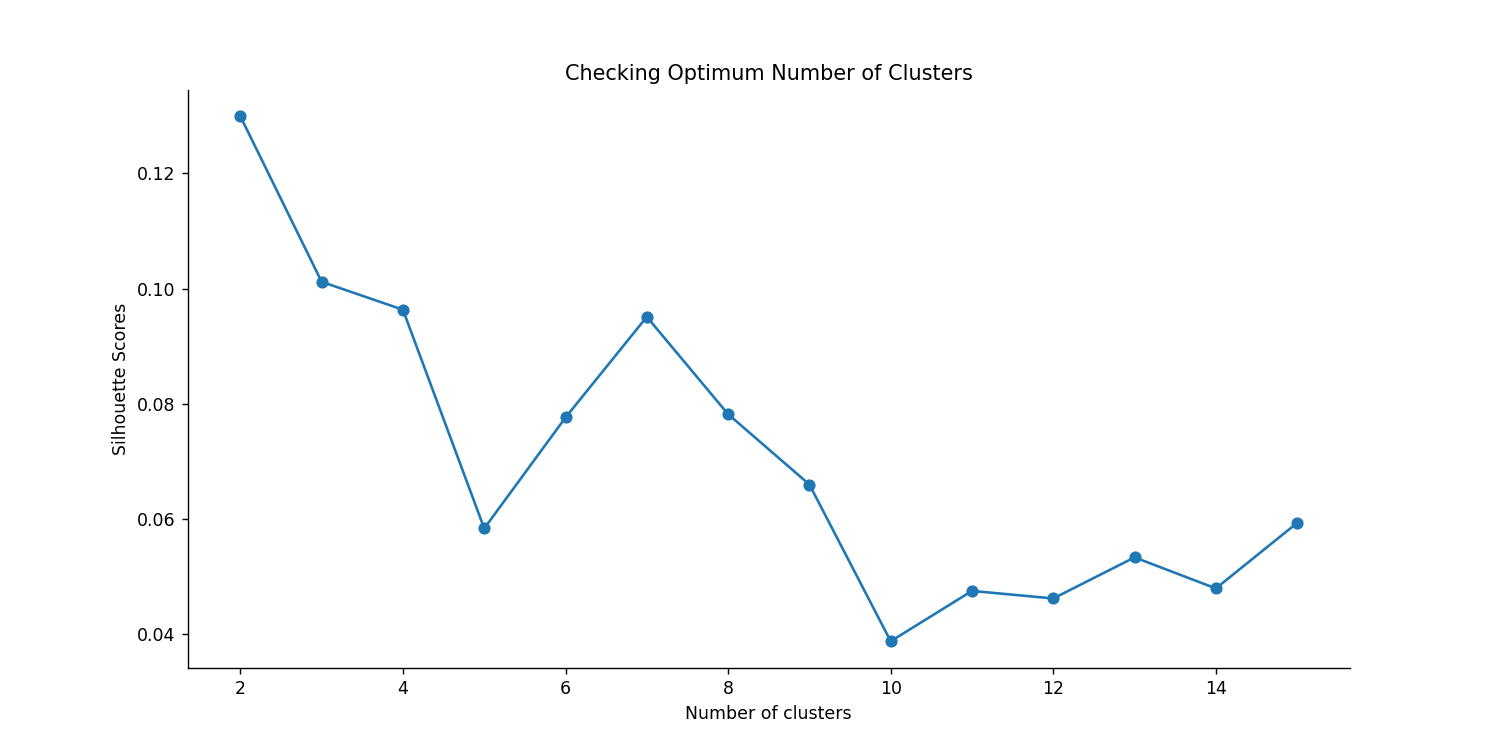

In [307]:
print(scores)
print(kval)
plot(kval, scores)

We will use 2 clusters since it gives out the highest score for all clusters 

In [220]:
k = 2

Ist_clustering = Ist_grouped.drop('Neighborhood', axis=1)
kmeans = KMeans(n_clusters=k, init="k-means++", random_state=40).fit(Ist_clustering) #Can choose any random_state

kmeans.labels_

array([5, 2, 3, 2, 2, 2, 3, 6, 0, 4, 1, 3, 5, 2, 2, 3, 2, 2, 2, 0, 2, 0,
       4, 2, 2, 2, 4, 2, 2, 1, 1, 2, 2, 1, 3, 1, 3, 4, 0])

In [221]:
df.rename(columns = {'District':'Neighborhood'},inplace = True)

Now we merge our initial dataframe with the most common venues datafram created using the data from foursquare

In [222]:
Ist_merged = df
Ist_merged = Ist_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

print(Ist_merged.shape)
Ist_merged

(39, 16)


,Neighborhood,Population (2020),Area (km²),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adalar,16033.0,11.05,40.86306,29.12423,1,Hotel,Beach,Café,Bed & Breakfast,Harbor / Marina,Historic Site,Mountain,Cafeteria,Park,Road
1,Arnavutköy,296709.0,450.35,41.18558,28.74147,0,Café,Turkish Restaurant,Shopping Mall,Dessert Shop,Restaurant,Fast Food Restaurant,Shoe Store,Cafeteria,Steakhouse,Clothing Store
2,Ataşehir,422594.0,25.23,40.99248,29.12777,1,Restaurant,Coffee Shop,Seafood Restaurant,Pizza Place,Steakhouse,Gym,Kebab Restaurant,Meyhane,Park,Pool
3,Avcılar,436897.0,42.01,40.97813,28.72101,0,Café,Dessert Shop,Gym / Fitness Center,Coffee Shop,Bar,Restaurant,Turkish Restaurant,Gym,Sporting Goods Shop,Mobile Phone Shop
4,Bağcılar,737206.0,22.36,41.03323,28.86351,0,Café,Gym,Turkish Restaurant,Dessert Shop,Coffee Shop,Steakhouse,Furniture / Home Store,Breakfast Spot,Snack Place,Beach
5,Bahçelievler,592371.0,16.62,40.99805,28.84737,0,Café,Turkish Restaurant,Kebab Restaurant,Dessert Shop,Steakhouse,Tea Room,Bakery,Gym,Middle Eastern Restaurant,Motorcycle Shop
6,Bakırköy,226229.0,29.64,40.98273,28.87480,1,Café,Bakery,Coffee Shop,Fast Food Restaurant,Kebab Restaurant,Gym,Turkish Restaurant,Dessert Shop,Clothing Store,Restaurant
7,Başakşehir,469924.0,104.30,41.10745,28.80061,0,Café,Kebab Restaurant,Dessert Shop,Restaurant,Steakhouse,Park,Music Venue,Nail Salon,Soccer Field,Arcade
8,Bayrampaşa,269950.0,9.61,41.04381,28.91214,1,Café,Turkish Restaurant,Hotel,Restaurant,Gym / Fitness Center,Soup Place,Ice Cream Shop,Dessert Shop,Soccer Field,Breakfast Spot
9,Beşiktaş,176513.0,18.01,41.04190,29.00575,1,Café,Coffee Shop,Hotel,Dessert Shop,Bar,Lounge,Performing Arts Venue,Chocolate Shop,Restaurant,Historic Site


We can visualize the 2 different clusters using the map in folium

In [223]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(Ist_merged['Latitude'], Ist_merged['Longitude'], Ist_merged['Neighborhood'], Ist_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [224]:
Ist_merged.loc[Ist_merged['Cluster Labels'] == 0, Ist_merged.columns[[0] + [1] + list(range(5, Ist_merged.shape[1]))]]

,Neighborhood,Population (2020),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Arnavutköy,296709.0,0,Café,Turkish Restaurant,Shopping Mall,Dessert Shop,Restaurant,Fast Food Restaurant,Shoe Store,Cafeteria,Steakhouse,Clothing Store
3,Avcılar,436897.0,0,Café,Dessert Shop,Gym / Fitness Center,Coffee Shop,Bar,Restaurant,Turkish Restaurant,Gym,Sporting Goods Shop,Mobile Phone Shop
4,Bağcılar,737206.0,0,Café,Gym,Turkish Restaurant,Dessert Shop,Coffee Shop,Steakhouse,Furniture / Home Store,Breakfast Spot,Snack Place,Beach
5,Bahçelievler,592371.0,0,Café,Turkish Restaurant,Kebab Restaurant,Dessert Shop,Steakhouse,Tea Room,Bakery,Gym,Middle Eastern Restaurant,Motorcycle Shop
7,Başakşehir,469924.0,0,Café,Kebab Restaurant,Dessert Shop,Restaurant,Steakhouse,Park,Music Venue,Nail Salon,Soccer Field,Arcade
10,Beykoz,246110.0,0,Café,Seafood Restaurant,Restaurant,Gym,Plaza,Sculpture Garden,Fast Food Restaurant,Department Store,Music Venue,Electronics Store
13,Büyükçekmece,257362.0,0,Café,Restaurant,Turkish Restaurant,Coffee Shop,Art Gallery,Steakhouse,Food Court,Seafood Restaurant,Dessert Shop,Salon / Barbershop
14,Çatalca,74975.0,0,Café,Turkish Restaurant,Mobile Phone Shop,Restaurant,Pizza Place,Grocery Store,Park,Coffee Shop,Bakery,Fast Food Restaurant
16,Esenler,446276.0,0,Café,Gym,Gym / Fitness Center,Restaurant,Clothing Store,Pizza Place,Snack Place,Turkish Restaurant,Electronics Store,Fast Food Restaurant
17,Esenyurt,957398.0,0,Café,Kebab Restaurant,Park,Pool,Electronics Store,Plaza,Dessert Shop,Pizza Place,Garden,Bakery


In [225]:
Ist_merged.loc[Ist_merged['Cluster Labels'] == 1, Ist_merged.columns[[0] + [1] + list(range(5, Ist_merged.shape[1]))]]

,Neighborhood,Population (2020),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adalar,16033.0,1,Hotel,Beach,Café,Bed & Breakfast,Harbor / Marina,Historic Site,Mountain,Cafeteria,Park,Road
2,Ataşehir,422594.0,1,Restaurant,Coffee Shop,Seafood Restaurant,Pizza Place,Steakhouse,Gym,Kebab Restaurant,Meyhane,Park,Pool
6,Bakırköy,226229.0,1,Café,Bakery,Coffee Shop,Fast Food Restaurant,Kebab Restaurant,Gym,Turkish Restaurant,Dessert Shop,Clothing Store,Restaurant
8,Bayrampaşa,269950.0,1,Café,Turkish Restaurant,Hotel,Restaurant,Gym / Fitness Center,Soup Place,Ice Cream Shop,Dessert Shop,Soccer Field,Breakfast Spot
9,Beşiktaş,176513.0,1,Café,Coffee Shop,Hotel,Dessert Shop,Bar,Lounge,Performing Arts Venue,Chocolate Shop,Restaurant,Historic Site
11,Beylikdüzü,365572.0,1,Café,Clothing Store,Turkish Restaurant,Coffee Shop,Restaurant,Steakhouse,Shopping Mall,Gym / Fitness Center,Music Venue,Sporting Goods Shop
12,Beyoğlu,226396.0,1,Hotel,Café,Coffee Shop,Soccer Stadium,Art Gallery,Pizza Place,Dance Studio,Nightclub,Breakfast Spot,Museum
15,Çekmeköy,273658.0,1,Café,Bakery,Turkish Restaurant,Pizza Place,Restaurant,Dessert Shop,Park,Gym / Fitness Center,Gym,Comfort Food Restaurant
19,Fatih,396594.0,1,Café,Dessert Shop,Bridal Shop,Mosque,Turkish Restaurant,Restaurant,Gym,Hotel,Kebab Restaurant,Tea Room
21,Güngören,280299.0,1,Turkish Restaurant,Dessert Shop,Kebab Restaurant,Steakhouse,Café,Department Store,Gym / Fitness Center,Restaurant,Sporting Goods Shop,Spa


In [233]:
new_restaurant_neighborhoods = Ist_merged.loc[Ist_merged['Cluster Labels'] == 0, Ist_merged.columns[[0, 1, 2, 3] + list(range(5, Ist_merged.shape[1]))]]
new_restaurant_neighborhoods

,Neighborhood,Population (2020),Area (km²),Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Arnavutköy,296709.0,450.35,41.18558,0,Café,Turkish Restaurant,Shopping Mall,Dessert Shop,Restaurant,Fast Food Restaurant,Shoe Store,Cafeteria,Steakhouse,Clothing Store
3,Avcılar,436897.0,42.01,40.97813,0,Café,Dessert Shop,Gym / Fitness Center,Coffee Shop,Bar,Restaurant,Turkish Restaurant,Gym,Sporting Goods Shop,Mobile Phone Shop
4,Bağcılar,737206.0,22.36,41.03323,0,Café,Gym,Turkish Restaurant,Dessert Shop,Coffee Shop,Steakhouse,Furniture / Home Store,Breakfast Spot,Snack Place,Beach
5,Bahçelievler,592371.0,16.62,40.99805,0,Café,Turkish Restaurant,Kebab Restaurant,Dessert Shop,Steakhouse,Tea Room,Bakery,Gym,Middle Eastern Restaurant,Motorcycle Shop
7,Başakşehir,469924.0,104.30,41.10745,0,Café,Kebab Restaurant,Dessert Shop,Restaurant,Steakhouse,Park,Music Venue,Nail Salon,Soccer Field,Arcade
10,Beykoz,246110.0,310.36,41.12647,0,Café,Seafood Restaurant,Restaurant,Gym,Plaza,Sculpture Garden,Fast Food Restaurant,Department Store,Music Venue,Electronics Store
13,Büyükçekmece,257362.0,139.17,41.02046,0,Café,Restaurant,Turkish Restaurant,Coffee Shop,Art Gallery,Steakhouse,Food Court,Seafood Restaurant,Dessert Shop,Salon / Barbershop
14,Çatalca,74975.0,1115.13,41.14369,0,Café,Turkish Restaurant,Mobile Phone Shop,Restaurant,Pizza Place,Grocery Store,Park,Coffee Shop,Bakery,Fast Food Restaurant
16,Esenler,446276.0,18.43,41.03932,0,Café,Gym,Gym / Fitness Center,Restaurant,Clothing Store,Pizza Place,Snack Place,Turkish Restaurant,Electronics Store,Fast Food Restaurant
17,Esenyurt,957398.0,43.13,41.03246,0,Café,Kebab Restaurant,Park,Pool,Electronics Store,Plaza,Dessert Shop,Pizza Place,Garden,Bakery


## Conclusion of the First Part
We can see that cafés are a large majority in all the districts of Istsnbul, however differences arise in second and third choice and the differences are quite varied on each district. Overall restaurants are very common on every district of Istanbul so it is quite difficul to come up with the optimal district to open a restaurant. Other factors should be considered to come up with a decision to open a restaurant.

## Part 2: Looking for a relationship between Population Density and Household Income

Istanbul is one of the most densely populated areas in Turkey, it also is the location in which the wealthiest part of the population lives.  In this part, I will use the same dataframe extracted from wikipedia to look for a relationship between population density and household incmoe of each region. 

In [238]:
df2 = pd.read_html('https://en.wikipedia.org/wiki/List_of_districts_of_Istanbul')[0]
df2 = pd.DataFrame(df)
df2.head()

,District,Population (2020),Area (km²),Density (per km²),Mensual household income TL(USD),Annual household income TL(USD)
0,Adalar,16033,11.05,1451,6.652₺ (918$),"79.821₺ (10,978$)"
1,Arnavutköy,296709,450.35,659,2.030₺ (279$),"24.360₺ (3,350$)"
2,Ataşehir,422594,25.23,16750,6.577₺ (904$),"78.924₺ (10,854$)"
3,Avcılar,436897,42.01,10400,3.662₺ (503$),"43.938₺ (6,064$)"
4,Bağcılar,737206,22.36,32970,3.197₺ (441$),"38.367₺ (5,295$)"


In [236]:
df2.dtypes

District                            object
Population (2020)                    int64
Area (km²)                          object
Density (per km²)                    int64
Mensual household income TL(USD)    object
Annual household income TL(USD)     object
dtype: object

Extract Household income in USD values as an integer

In [250]:

df2['Annual household income USD'] = df2['Annual household income TL(USD)'].str.extract(r"\((.*?)\)", expand=False)
df2.head()

,District,Population (2020),Area (km²),Density (per km²),Mensual household income TL(USD),Annual household income TL(USD),Annual household income TL,Annual household income USD
0,Adalar,16033,11.05,1451,6.652₺ (918$),"79.821₺ (10,978$)",79.821₺,"10,978$"
1,Arnavutköy,296709,450.35,659,2.030₺ (279$),"24.360₺ (3,350$)",24.360₺,"3,350$"
2,Ataşehir,422594,25.23,16750,6.577₺ (904$),"78.924₺ (10,854$)",78.924₺,"10,854$"
3,Avcılar,436897,42.01,10400,3.662₺ (503$),"43.938₺ (6,064$)",43.938₺,"6,064$"
4,Bağcılar,737206,22.36,32970,3.197₺ (441$),"38.367₺ (5,295$)",38.367₺,"5,295$"


In [ ]:
#Drop the columns that are useless
df2.drop(columns = ['Mensual household income TL(USD)','Annual household income TL(USD)','Annual household income TL'],inplace = True)

In [ ]:
#Convert the data type of household income to string so that it can be used in regression analysis
df2['Annual household income USD'] = df2['Annual household income USD'].str.split('$').str[0]
df2['Annual household income USD'] = df2['Annual household income USD'].str.replace(',','').astype('float')

In [263]:
df2.head()

,District,Population (2020),Area (km²),Density (per km²),Annual household income USD
0,Adalar,16033,11.05,1451,10978.0
1,Arnavutköy,296709,450.35,659,3350.0
2,Ataşehir,422594,25.23,16750,10854.0
3,Avcılar,436897,42.01,10400,6064.0
4,Bağcılar,737206,22.36,32970,5295.0


In [267]:
df2.rename(columns = {'Density (per km²)':'Density_per_km2','Annual household income USD':'Annual_household_inc_USD'},inplace = True)

In [273]:
df2

,District,Population (2020),Area (km²),Density_per_km2,Annual_household_inc_USD
0,Adalar,16033,11.05,1451,10978.000
1,Arnavutköy,296709,450.35,659,3350.000
2,Ataşehir,422594,25.23,16750,10854.000
3,Avcılar,436897,42.01,10400,6064.000
4,Bağcılar,737206,22.36,32970,5295.000
5,Bahçelievler,592371,16.62,35642,7741.000
6,Bakırköy,226229,29.64,7633,14650.000
7,Başakşehir,469924,104.30,4506,7474.000
8,Bayrampaşa,269950,9.61,28091,5764.000
9,Beşiktaş,176513,18.01,9801,17490.000


In [276]:
df2.drop(index = [39,40,41,42],inplace = True)
df2

,District,Population (2020),Area (km²),Density_per_km2,Annual_household_inc_USD
0,Adalar,16033,11.05,1451,10978.000
1,Arnavutköy,296709,450.35,659,3350.000
2,Ataşehir,422594,25.23,16750,10854.000
3,Avcılar,436897,42.01,10400,6064.000
4,Bağcılar,737206,22.36,32970,5295.000
5,Bahçelievler,592371,16.62,35642,7741.000
6,Bakırköy,226229,29.64,7633,14650.000
7,Başakşehir,469924,104.30,4506,7474.000
8,Bayrampaşa,269950,9.61,28091,5764.000
9,Beşiktaş,176513,18.01,9801,17490.000


Now that, we have cleaned the dataset, I am going to analyze the relationship between population density and Annual household income, then, I am going to try to predict annual household income using the population density in the given area

<function matplotlib.pyplot.show(*args, **kw)>

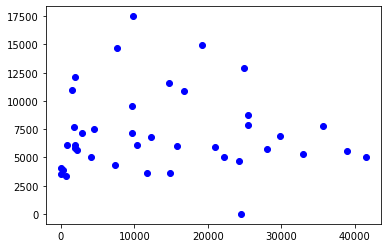

In [271]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.scatter(df2.Density_per_km2, df2.Annual_household_inc_USD, color = 'blue')
plt.show

In [277]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()

X = df2[['Density_per_km2']]
Y = df2[['Annual_household_inc_USD']]

lm.fit(X,Y)

LinearRegression()

In [278]:
Yhat=lm.predict(X)
Yhat[0:5]   

array([[7297.0289787 ],
       [7303.94490467],
       [7163.43459554],
       [7218.88425454],
       [7021.79782877]])

In [279]:
print('Intercept: {} \nSlope: {}'.format(lm.intercept_,lm.coef_))

Intercept: [7309.69944409] 
Slope: [[-0.00873223]]


(0.0, 18364.1982)

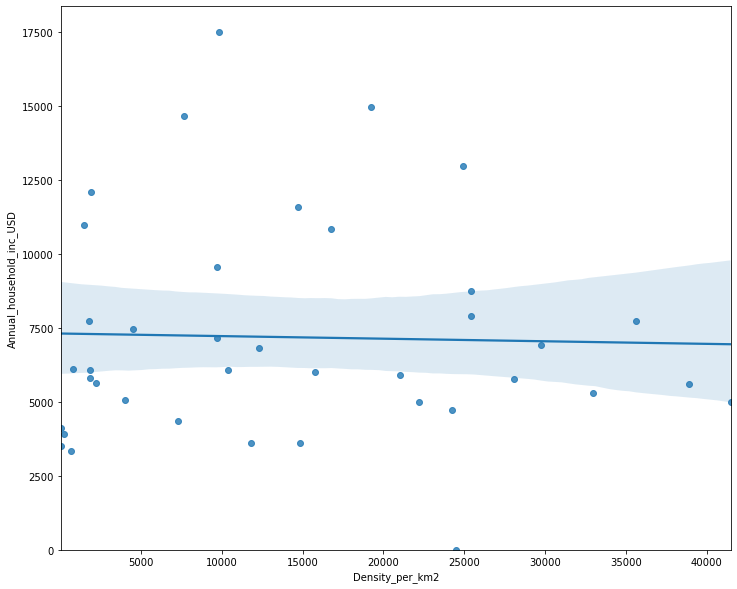

In [282]:
import seaborn as sns

width = 12
height = 10
plt.figure(figsize=(width, height))
sns.regplot(x=X, y=Y, data=df2)
plt.ylim(0,)

From the plot, we see that there is no linear relationship between population density and annual household income 

### Model Evaluation

In [283]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=1)


print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples : 4
number of training samples: 35


In [286]:
from sklearn.model_selection import cross_val_score

Rcross = cross_val_score(lm, X, Y, cv=4)
Rcross

array([-0.3445093 , -0.93410897, -0.05702373, -0.31263518])

In [287]:
print("The mean of the folds are", Rcross.mean(), "and the standard deviation is" , Rcross.std())

The mean of the folds are -0.41206929738672565 and the standard deviation is 0.32133871339358205


Quantifying our results proves again that there is no significant relationship between household income and population density, hence we cannot build a model that can predict the household income with confidence.